In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize as op
import scipy.signal as sig
from   scipy import stats
from   scipy import fftpack
import astropy
from   astropy.io import fits as pyfits
import random

import csv
import sys
import os
import importlib as imp
import glob
from   timeit import default_timer as timer
import warnings
import progressbar
import argparse
import json

import lightkurve as lk
import exoplanet as exo
import theano.tensor as T
import pymc3 as pm
import corner

from alderaan.constants import *
from alderaan.utils import *
from alderaan.Planet import *
from alderaan.LiteCurve import *
import alderaan.io as io
import alderaan.detrend as detrend
import alderaan.noise as noise


# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

In [2]:
# select mission, target, and paths

MISSION = "Kepler"
TARGET  = "K00277"
PRIMARY_DIR = '/Users/research/projects/alderaan/'
TRACE_FILE  = '/Users/research/projects/alderaan/Traces/K00277/K00277_sin_ttvs.fits'

# Make sure the necessary paths exist

In [3]:
# directory in which to find lightcurve data
if MISSION == 'Kepler': DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
if MISSION == 'Simulated': DOWNLOAD_DIR = PRIMARY_DIR + 'Simulations/'

# directories in which to place pipeline outputs    
FIGURE_DIR    = PRIMARY_DIR + 'Figures/' + TARGET + '/'
TRACE_DIR     = PRIMARY_DIR + 'Traces/' + TARGET + '/'
QUICK_TTV_DIR = PRIMARY_DIR + 'QuickTTVs/' + TARGET + '/'
DLC_DIR       = PRIMARY_DIR + 'Detrended_lightcurves/' + TARGET + '/'
NOISE_DIR     = PRIMARY_DIR + 'Noise_models/' + TARGET + '/'

# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)
    
if os.path.exists(TRACE_DIR) == False:
    os.mkdir(TRACE_DIR)
    
if os.path.exists(QUICK_TTV_DIR) == False:
    os.mkdir(QUICK_TTV_DIR)
    
if os.path.exists(DLC_DIR) == False:
    os.mkdir(DLC_DIR)
    
if os.path.exists(NOISE_DIR) == False:
    os.mkdir(NOISE_DIR)

# Get sinusoidal TTV model posteriors

In [4]:
# Read in the fits file with saved traces

with pyfits.open(TRACE_FILE) as sin_trace:
    header  = sin_trace[0].header
    hdulist = pyfits.HDUList(sin_trace)
    
    NDRAWS, NPL = sin_trace['RP'].shape
    
    # stellar parameters
    RSTAR  = sin_trace['RSTAR'].data
    MSTAR  = sin_trace['MSTAR'].data
    U      = sin_trace['U'].data
    U1, U2 = U[:,0], U[:,1]
    
    # planetary parameters
    T0   = sin_trace['T0'].data
    P    = sin_trace['P'].data
    LOGR = sin_trace['LOGR'].data
    RP   = sin_trace['RP'].data
    B    = sin_trace['B'].data
    
    # TTV parameters
    C0 = sin_trace['C0'].data
    C1 = sin_trace['C1'].data
    C2 = np.zeros_like(C0)
    C3 = np.zeros_like(C0)
    C4 = np.zeros_like(C0)
    C5 = np.zeros_like(C0)
    
    A1 = np.zeros_like(C0)
    B1 = np.zeros_like(C0)
    A2 = np.zeros_like(C0)
    B2 = np.zeros_like(C0)
    AMP = np.zeros_like(C0)
    
    FPLUS  = np.zeros_like(C0)
    FMINUS = np.zeros_like(C0)
    FTTV1  = np.zeros_like(C0)
    FTTV2  = np.zeros_like(C0)
    
    TTS = [None]*NPL
    
    for npl in range(NPL):
        try: C2[:,npl] = sin_trace['C2_{0}'.format(npl)].data
        except: pass
        
        try: C3[:,npl] = sin_trace['C3_{0}'.format(npl)].data
        except: pass
        
        try: C4[:,npl] = sin_trace['C4_{0}'.format(npl)].data
        except: pass
        
        try: C5[:,npl] = sin_trace['C5_{0}'.format(npl)].data
        except: pass
        
        try: A1[:,npl] = sin_trace['A1_{0}'.format(npl)].data
        except: pass
        
        try: B1[:,npl] = sin_trace['B1_{0}'.format(npl)].data
        except: pass
        
        try: A2[:,npl] = sin_trace['A2_{0}'.format(npl)].data
        except: pass
        
        try: B2[:,npl] = sin_trace['B2_{0}'.format(npl)].data
        except: pass
        
        try: AMP[:,npl] = sin_trace['amp_{0}'.format(npl)].data
        except: pass
        
        try: FPLUS[:,npl] = sin_trace['FPLUS_{0}'.format(npl)].data
        except: pass
        
        try: FMINUS[:,npl] = sin_trace['FMINUS_{0}'.format(npl)].data
        except: pass
        
        try: FTTV1[:,npl] = sin_trace['FTTV1_{0}'.format(npl)].data
        except: pass
        
        try: FTTV2[:,npl] = sin_trace['FTTV2_{0}'.format(npl)].data
        except: pass       
        
        try: TTS[npl] = sin_trace['TTS_{0}'.format(npl)].data
        except: pass

In [5]:
with pyfits.open(TRACE_FILE) as sin_trace:
    header  = sin_trace[0].header
    hdulist = pyfits.HDUList(sin_trace)
    
    NDRAWS, NPL = sin_trace['RP'].shape
    
    # GP parameters
    LOGSW4 = np.zeros((NDRAWS,4))
    LOGW0  = np.zeros((NDRAWS,4))
    LOGQ   = np.zeros((NDRAWS,4))
    
    for z in range(4):
        try: LOGSW4[:,z] = sin_trace['LOGSW4_{0}'.format(z)].data
        except: pass
        
        try: LOGW0[:,z] = sin_trace['LOGW0_{0}'.format(z)].data
        except: pass
        
        try: LOGQ[:,z] = sin_trace['LOGQ_{0}'.format(z)].data
        except: pass

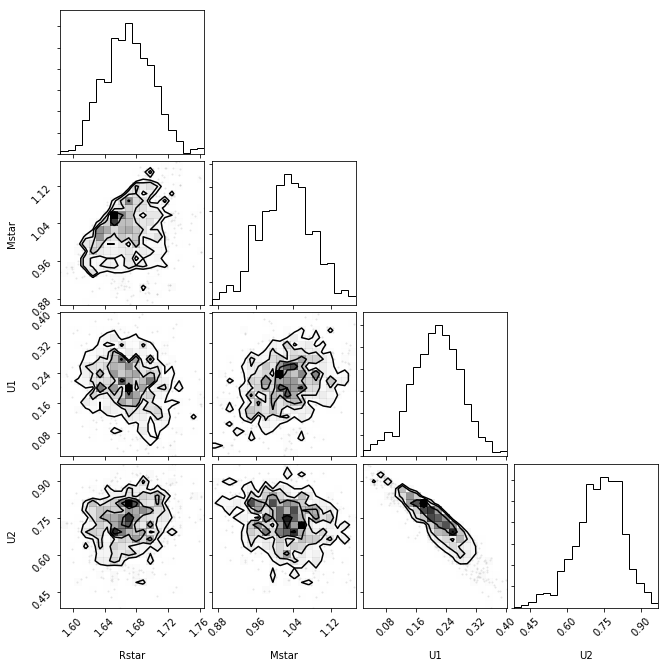

In [6]:
data = np.stack([RSTAR, MSTAR, U1, U2]).swapaxes(0,1)
labels = ['Rstar', 'Mstar', 'U1', 'U2']

fig = corner.corner(data, labels=labels)

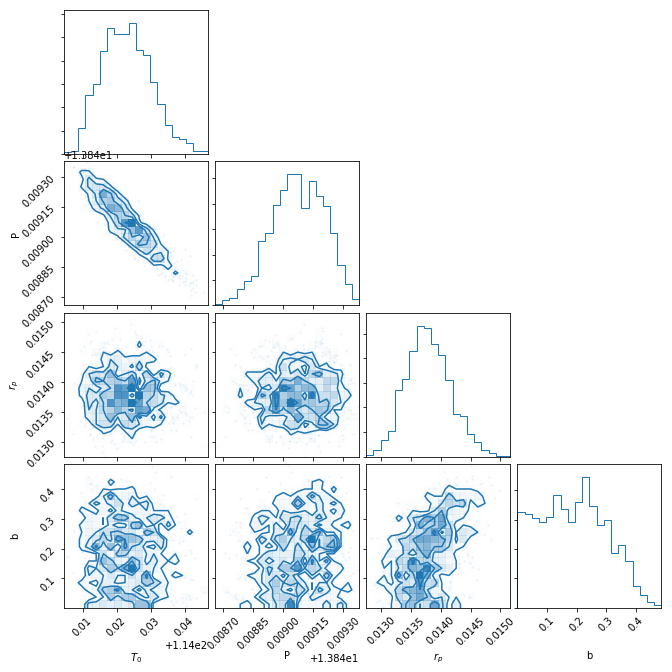

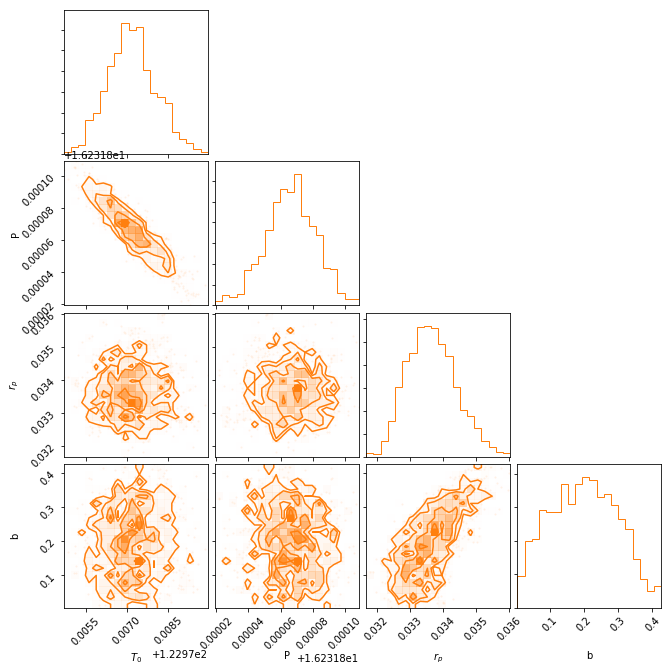

In [7]:
for npl in range(NPL):
    data = np.stack([T0[:,npl], P[:,npl], RP[:,npl], B[:,npl]]).swapaxes(0,1)
    labels = ['$T_0$', 'P', '$r_p$', 'b']

    fig = corner.corner(data, labels=labels, color='C{0}'.format(npl))

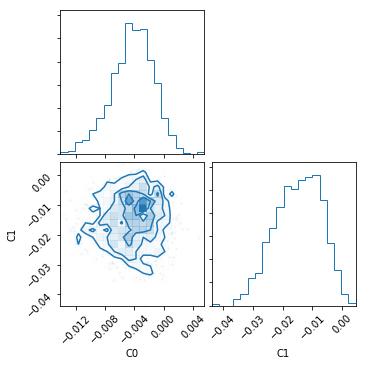

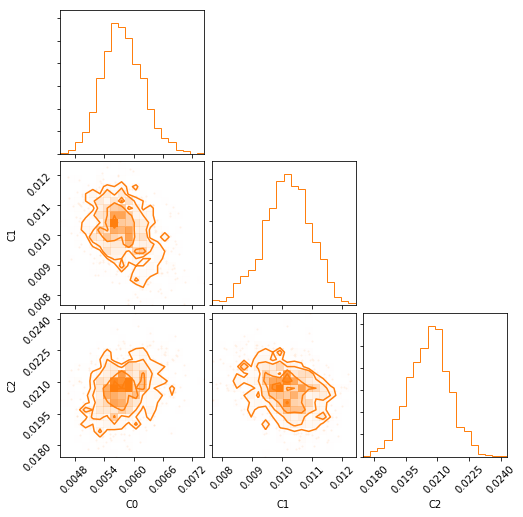

In [8]:
for npl in range(NPL):
    try:
        data = np.stack([C0[:,npl], C1[:,npl], C2[:,npl], C3[:,npl]]).swapaxes(0,1)
        labels = ['C0', 'C1', 'C2', 'C3']

        fig = corner.corner(data, labels=labels, color='C{0}'.format(npl))
        
    except:
        try:
            data = np.stack([C0[:,npl], C1[:,npl], C2[:,npl]]).swapaxes(0,1)
            labels = ['C0', 'C1', 'C2']

            fig = corner.corner(data, labels=labels, color='C{0}'.format(npl))
        
        except:
            try:
                data = np.stack([C0[:,npl], C1[:,npl]]).swapaxes(0,1)
                labels = ['C0', 'C1']

                fig = corner.corner(data, labels=labels, color='C{0}'.format(npl))

            except:
                pass

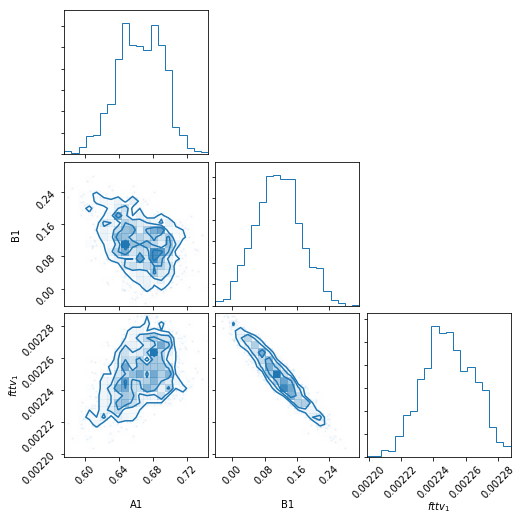

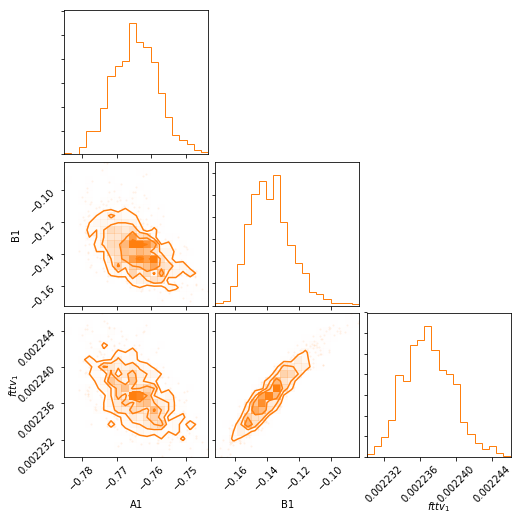

In [9]:
for npl in range(NPL):
    try:
        data = np.stack([A1[:,npl], B1[:,npl], A2[:,npl], B2[:,npl], \
                        FTTV1[:,npl], FTTV2[:,npl]]).swapaxes(0,1)
        labels = ['A1', 'B1', 'A2', 'B2', '$fttv_1$', '$fttv_2$']
        fig = corner.corner(data, labels=labels, color='C{0}'.format(npl))
        
    except:
        try:
            data = np.stack([A1[:,npl], B1[:,npl], FTTV1[:,npl]]).swapaxes(0,1)
            labels = ['A1', 'B1', '$fttv_1$']
            fig = corner.corner(data, labels=labels, color='C{0}'.format(npl))
        except:
            pass


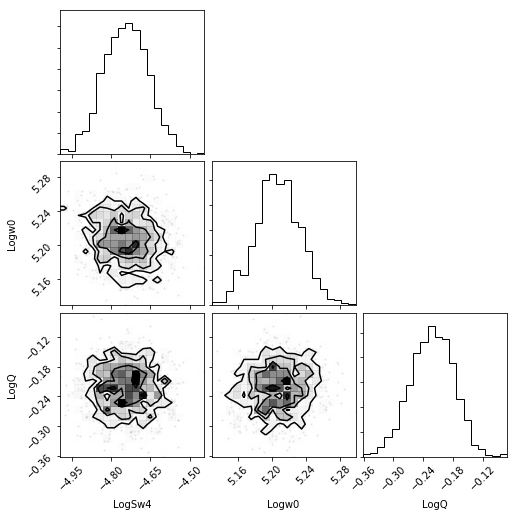

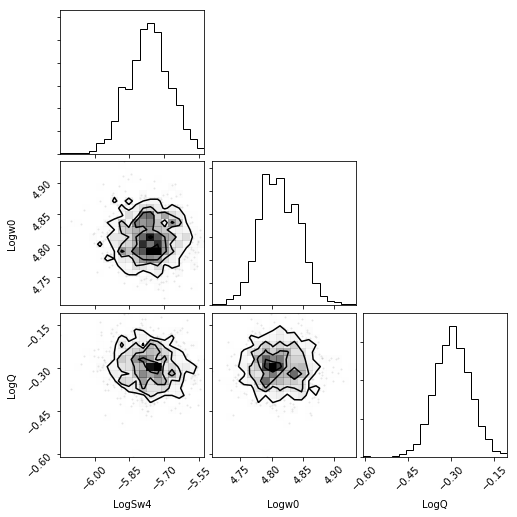

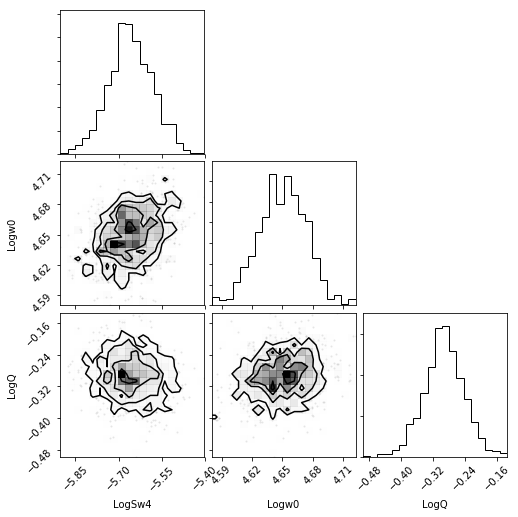

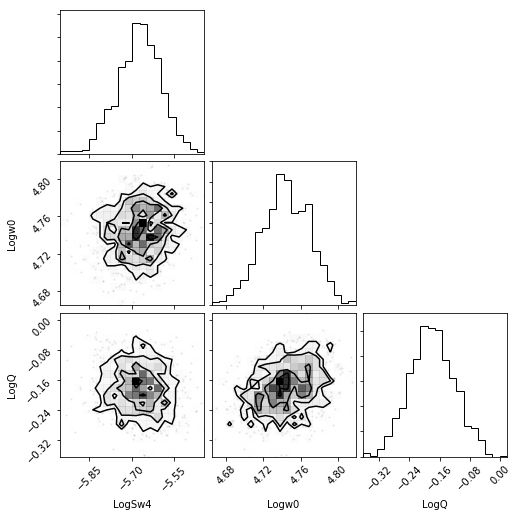

In [10]:
for z in range(4):
    data  = []
    labels = []

    if np.sum(LOGSW4[:,z] != 0):
        data.append(LOGSW4[:,z])
        labels.append('LogSw4')
        
    if np.sum(LOGW0[:,z] != 0):
        data.append(LOGW0[:,z])
        labels.append('Logw0')    
    
    if np.sum(LOGQ[:,z] != 0):
        data.append(LOGQ[:,z])
        labels.append('LogQ')
        
    
    try:
        data = np.stack(data).swapaxes(0,1)
        fig = corner.corner(data, labels=labels)
        
    except:
        pass

# Get transit times, linear ephemeris and O-C

In [11]:
epochs = np.zeros(NPL)
periods = np.zeros(NPL)

sin_transit_times = []
sin_ephemeris = []
transit_inds = []

for npl in range(NPL):   
    sin_transit_times.append(np.median(TTS[npl], axis=0))
    
    t0  = np.median(T0[:,npl])
    per = np.median(P[:,npl])
    tts = sin_transit_times[npl]
    
    tinds = np.array(np.floor((tts - t0 + per/2) / per), dtype='int')
    
    epochs[npl] = t0
    periods[npl] = per
    sin_ephemeris.append(t0 + per*tinds)
    transit_inds.append(tinds)

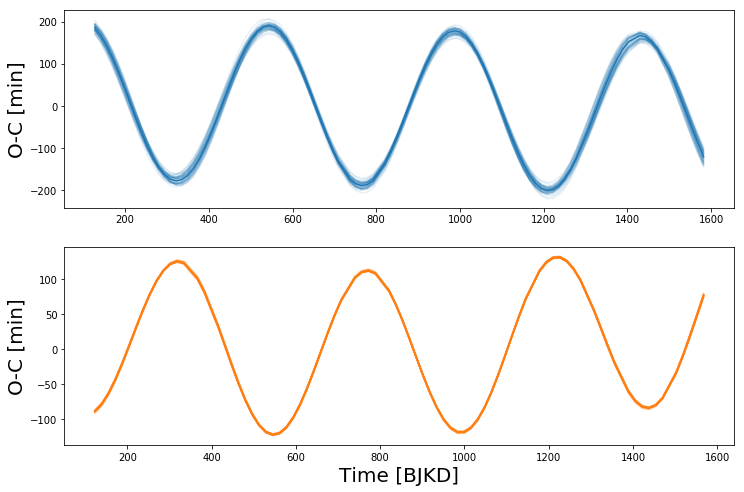

In [12]:
draws = random.sample(range(NDRAWS), 50)

fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl in range(NPL):
    for d in draws:
        xtime = TTS[npl][d]
        yomc  = (xtime - (T0[d,npl] + P[d,npl]*transit_inds[npl]))*24*60

        axes[npl].plot(xtime, yomc, alpha=0.1, color='C{0}'.format(npl))    
    
    xtime = sin_transit_times[npl]
    yomc  = (sin_transit_times[npl]-sin_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, color='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
    
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)    
plt.show()